**学生用**

# 2019年度知識情報演習III（後半）ノートブック 4
本ノートブックでは、情報検索システムにおける文書の順位付け処理を理解しながら、Pythonでプログラムを作成していきます。

## 完了の目安
本ノートブックは、後半第4回（今回）の終わりか、第5回（次回）の前半までに完了することを目安にしましょう。

---
## ノートブック3の演習内容をTAか教員に確認してもらってから、ノートブック4に進んでください。ただし確認待ちの間に先に進めるのは構いません。

---
## 【重要】本演習の学習方針

プログラミングでは、ある問題を解決するための方法が複数存在するのが普通です。しかし本演習では、Pythonを使ったプログラミングにおいて**標準的な実装方法**を身につけることを重視します。したがって、以下の点に注意して演習を進めてください。

- プログラムを作成する際に、ノートブックで説明されたやり方に沿って実装すること
  - TAや教員もノートブックで説明した実装方法が実践できているかを確認します
- 外部ウェブサイトなどで示された別の実装方法を参照した場合、プログラムが正常に機能したとしても**やり直しをしてもらう場合がある**
- 情報検索の仕組みを理解するために、便利なライブラリを意図的に使わない場合がある
- 情報検索システムの理解に直接関係ない複雑な処理に関して、便利なライブラリを使用する場合がある
- その他の関連情報については、参照URLを示すので、授業外活動として各自学習しておくこと

---
## 【重要】本演習の実行環境

プログラミングは、プログラムを実行する環境によって動作や出力結果が異なる場合があります。全学計算機システムの実行環境は以下の通りです。

- OS : Ubuntu 16.04 LTS
- Python : Anaconda Python 3 ver 5.2.0
- JupyterLab : 0.32.1
- Janome : 0.36

研究室や個人のパソコンを使った場合、上記の実行環境と異なると同じ結果が出ない場合やエラーが出る（あるいは出ない）場合がありますので、注意が必要です。本演習では上記実行環境以外の動作に関するサポートは行いません。

---
## 文書の順位付け

順位付け処理では、以下の手続きを順に行っていきます。

> 1. 順位付けの基礎とベクトル空間モデルの理解  
> 2. 索引ファイルの読み込みと各種重み値の取得  
> 3. ベクトル空間における文書と検索質問の表現  
> 4. 検索質問と文書の類似度の計算と順位づけ

---
### 演習用フォルダ構成の確認
作業を始める前に、演習用のフォルダが以下の構成になっていることを確認してください。  

```
ホームフォルダ
  ┗ CJE3
    ┣ ipynb
      ┣ CJE3_2019_Notebook_0.ipynb
      ┣ CJE3_2019_Notebook_1.ipynb
      ┣ CJE3_2019_Notebook_2.ipynb
      ┣ CJE3_2019_Notebook_3.ipynb
      ┣ CJE3_2019_Notebook_4.ipynb（新規ファイル）
      ┗ images
          ┗ nested_dict.png
    ┣ data
      ┣ sample_doc1.txt
      ┣ ...
      ┗ sample_doc10.txt
    ┗ index
        ┣ index.txt
        ┗ index2.txt（前回作成分）
```

---
### 順位付けの基礎

前回までの重み付けの処理の結果、各文書に現れる索引語の有用性を、弁別能力（**逆文書頻度**)や文書特徴量（**索引語頻度**)の二つの統計量を用いた`tfidf`法を使って計算しました。文書内の索引語の`tfidf`値を事前に求めたのは、検索結果の質を向上させるためでした。本演習では、いよいよ、検索結果の質の核心である、**文書の順位付け**（ランキング）について学びます。

みなさんが検索エンジンを使っている時に、検索結果の質が良い（あるいは役立つ）と感じるのは、多くの場合、以下のような結果が得られた時です。

> 検索質問（クエリ）に強く適合した文書が検索結果の上位にあり、弱く適合した文書が下位にある

すなわち、ユーザが入力した検索質問に対し、文書を効果的に順位付けできることが、情報検索システムにとって最も重要な機能の一つと言えます。また、検索質問に対してある文書がマッチしている度合いを**適合性**と呼び、英語では`relevance`（レレバンス）と言います。

前回の重み付け手法と同様に、**情報検索**という研究分野では、過去何十年にもわたって、多くの研究者が様々な順位付け手法を考案し、テストしてきました。

本演習では、その中でも基本中の基本である**ベクトル空間モデル**を実装することで、順位付け処理の基礎を学んでいきます。

---
### ベクトル空間モデルとは

ベクトル空間モデル（`VSM: Vector Space Model`）は、情報検索における順位付けの古典的な手法の一つです。ベクトル空間モデルの特徴は、文書や検索質問を、多次元のベクトル空間に表現することです。文書や検索質問をベクトル空間に表現することで、文書間や検索質問-文書間の類似度を測定できるようになります。

それでは、文書をベクトル空間に表現する例を見てみましょう。

---
まず「いぬ」と「ねこ」という二つの索引語しか存在しない世界を想像してください。そんな素敵な世界に3つの文書がありました。

- 文書1には「いぬ」が1回出現して、「ねこ」が4回出現します。
- 文書2には「いぬ」が1回出現して、「ねこ」が2回出現します。
- 文書3には「いぬ」が4回出現して、「ねこ」が1回出現します。

まとめると以下の表になります。

|　|いぬ|ねこ|
|:--:|:--:|:--:|
|文書1（`Doc1`）|1|4|
|文書2（`Doc2`）|1|2|
|文書3（`Doc3`）|4|1|

> **ヒント：** 文書群全体に出現した索引語の総数がベクトル空間の次元数になります。上の例では、索引語が「いぬ」と「ねこ」の二つですので、2次元のベクトル空間で文書を表現します。大規模なシステムでは、索引語が何十万もあるのが一般的であり（例えば、[広辞苑 第七版](https://www.iwanami.co.jp/book/b329781.html)には25万語が収録されています）、処理するベクトル空間の次元も同様の規模になります。

---
#### ベクトルの描画

それでは、文書1を2次元のベクトル空間に描画するプログラムを実行してみましょう。

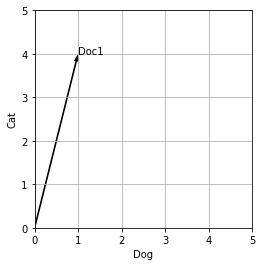

In [1]:
# 出力する画像をJupyter Notebook内に表示するためのおまじない
%matplotlib inline

# 必要なライブラリを読み込む
import matplotlib.pyplot as plt

# 全文書共通のx軸y軸の始点（0, 0）
start_x = 0 # x軸の始点
start_y = 0 # y軸の始点

# 文書1のX軸とY軸の値を索引語の出現回数を使って定義
doc1_x = 1 # x軸の終点（1: いぬの出現頻度）
doc1_y = 4 # y軸の終点（4: ねこの出現頻度）

# グラフの描画
plt.quiver(start_x, start_y, doc1_x, doc1_y, angles='xy', scale_units='xy', scale=1)
plt.text(1, 4, "Doc1") # 文書ラベルの追加（X軸座標、Y軸座標、ラベル）
plt.xlabel("Dog") # X軸ラベルの指定
plt.ylabel("Cat") # Y軸ラベルの指定
plt.axis('scaled')
plt.xlim([0,5])
plt.ylim([0,5])
plt.xticks(range(0,6))
plt.yticks(range(0,6))
plt.grid()
plt.draw()
plt.show()

---
X軸が索引語「いぬ（Dog）」の値、Y軸が索引語「ねこ（Cat）」の値とするベクトル（矢印）が描画されたら成功です。文書1は「いぬ」が1回、「ねこ」が4回出現する文書ですので、ベクトルの終点が（1, 4）になっています。

> これが文書をベクトル空間で表現する処理です。

ここではベクトル空間を使った文書の表現方法を視覚的に理解することが目的ですので、プログラムの詳細を理解する必要はありませんが、一応簡単に説明しておくと以下の通りです。

> 2: 描画するグラフをJupyter Notebook内に表示するためのおまじないです。Jupyter Notebook以外の環境でプログラムを実行する場合は不要です。  
> 5: 今回のグラフ描画に必要なライブラリ`matplotlib`を読み込みます。  
> 8-9: 文書1ベクトルの始点（x, y) = (0, 0)をそれぞれ、変数`start_x`と`start_y`に代入  
> 12-3: 文書1ベクトルの終点（x, y) = (1, 4)をそれぞれ、変数`doc1_x`と`doc1_y`に代入  
> 16-27: 矢印をグラフに描画するメソッド群  
> 17: ベクトルの終点に表示するラベル（`Doc1`）を表示位置座標と共に指定  
> 18-19: 軸のラベルをそれぞれ指定

---
#### 複数ベクトルの描画

つづいて文書2と3のベクトルも描画してみましょう。

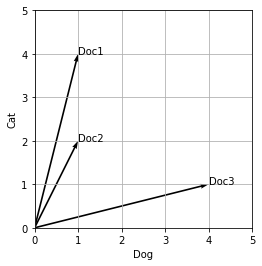

In [2]:
# 出力する画像をJupyter Notebook内に表示するためのおまじない
%matplotlib inline

# 必要なライブラリを読み込む
import matplotlib.pyplot as plt

# 全文書共通のx軸y軸の始点（0, 0）
start_x = 0 # x軸の始点
start_y = 0 # y軸の始点

# 文書1のX軸とY軸の値を索引語の出現回数を使って定義
doc1_x = 1 # x軸の終点（1: いぬの出現頻度）
doc1_y = 4 # y軸の終点（4: ねこの出現頻度）

# 文書2のX軸とY軸の値を索引語の出現回数を使って定義
doc2_x = 1 # x軸の終点（1: いぬの出現頻度）
doc2_y = 2 # y軸の終点（2: ねこの出現頻度）

# 文書3のX軸とY軸の値を索引語の出現回数を使って定義
doc3_x = 4 # x軸の終点（4: いぬの出現頻度）
doc3_y = 1 # y軸の終点（1: ねこの出現頻度）

# 文書1-3のベクトル情報を配列に代入
all_x_start = [start_x, start_x, start_x] # 文書1のX軸始点, 文書2のX軸始点, 文書3のX軸始点
all_y_start = [start_y, start_y, start_y] # 文書1のY軸始点, 文書2のY軸始点, 文書3のY軸始点
all_x_end = [doc1_x, doc2_x, doc3_x] # 文書1のX軸終点、文書2のX軸終点、文書3のX軸終点
all_y_end = [doc1_y, doc2_y, doc3_y] # 文書1のY軸終点、文書2のY軸終点、文書3のY軸終点

# グラフの描画
plt.quiver(all_x_start, all_y_start, all_x_end, all_y_end, angles='xy', scale_units='xy', scale=1)
plt.text(1, 4, "Doc1") # 文書ラベルの追加（X軸座標、Y軸座標、ラベル）
plt.text(1, 2, "Doc2") # 文書ラベルの追加（X軸座標、Y軸座標、ラベル）
plt.text(4, 1, "Doc3") # 文書ラベルの追加（X軸座標、Y軸座標、ラベル）
plt.xlabel("Dog") # X軸ラベルの指定
plt.ylabel("Cat") # Y軸ラベルの指定
plt.axis('scaled')
plt.xlim([0,5])
plt.ylim([0,5])
plt.xticks(range(0,6))
plt.yticks(range(0,6))
plt.grid()
plt.draw()
plt.show()

---
文書1から3のベクトルが表示され、それぞれの終点にラベルが表示されたら成功です。

一つのベクトルを描画する場合との主な変更点は以下の通りです。

> 16-7, 20-21: 文書1の終点を指定した時と同じやり方で、文書2の終点`doc2_x`と`doc2_y`と文書3の終点`doc3_x`と`doc3_y`を、それぞれの文書における「いぬ」と「ねこ」の出現頻度情報を使って指定する  
> 24-27: ベクトル描画をおこなう`plt.quiver`メソッドは、複数のベクトルを描画する際に、全てのベクトルの始点と終点を配列にまとめて指定する必要がある。したがって11-21行で指定した文書1-3の始点と終点を、`all_x_start`, `all_y_start`, `all_x_end`, `all_y_end`という4つの配列に代入している。また、全てのベクトルの始点は同値`(0,0)`なので、`start_x`と`start_y`を使いまわしている。  
> 30: 最後に、4つの配列を`plt.quiver`メソッドに渡しています。  
> 31-33: 文書1-3のラベルを指定しています。

---
### 文書間の類似度

ここまでで3つの文書をベクトル空間上に表現することができました。また、ベクトル空間上の終点の座標には、索引語の出現頻度を使いました。先に述べたように、文書をベクトル空間に表現することで、文書間の類似度や文書と検索質問の類似度を測定できるようになります。

それでは次に、文書間の類似度を計算する方法を学びましょう。

具体的には、二つの文書を表現する**二つのベクトルがなす鋭角**をその内積や余弦関数（コサイン）をもとめることで、文書間の類似度を計算します。つまり、二つのベクトルがなす鋭角が小さい（＝似た方角を向いている）ほど文書間の類似度は高く、鋭角が大きい（＝別の方角を向いている）ほど類似度が低いと判断します。

> 本演習では、余弦関数を用いる方法を実装します。


二つのベクトル（$\vec{a}$と$\vec{b}$）がなす鋭角の余弦関数 $\cos(\vec{a}, \vec{b})$ は以下のように定義されます。

$
\cos(\vec{a}, \vec{b}) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}| \cdot |\vec{b}|}
$

ここでは、$\vec{a}$ が文書1を表現するベクトル、$\vec{b}$ が文書2のベクトル、$\cos(\vec{a}, \vec{b})$ がその二つのベクトルがなす鋭角の余弦関数、と考えてください。

---
それでは、**余弦関数式の分子**から見ていきましょう。

$\vec{a} \cdot \vec{b}$ は二つのベクトルの内積です。2次元のベクトルの場合、内積は以下のように展開できます。

$
\vec{a} \cdot \vec{b} = a_1 \times b_1 + a_2 \times b_2
$

文書間の類似度計算におけるそれぞれの変数の意味は以下の通りです。

- $a_1$：文書1の「いぬ」の出現頻度（＝1）
- $a_2$：文書1の「ねこ」の出現頻度（＝4）
- $b_1$：文書2の「いぬ」の出現頻度（＝1）
- $b_2$：文書2の「ねこ」の出現頻度（＝2）

したがって、文書1（$\vec{a}$）と文書2（$\vec{b}$）の場合：

$
\vec{a} \cdot \vec{b} = 1 \times 1 + 4 \times 2 = 9
$

文書1（$\vec{a}$）と文書3（$\vec{c}$）の場合：

$
\vec{a} \cdot \vec{c} = 1 \times 4 + 4 \times 1 = 8
$

と計算することができます。

> ちなみに、ベクトルの次元（＝索引語の語彙数）が $n$ 個ある場合は、$\vec{a} \cdot \vec{b} = a_1 \times b_1 + a_2 \times b_2 + ... + a_n \times b_n $ となります。

---
次に、**余弦関数式の分母**を見ていきましょう。

こちらは、ベクトルの大きさ（長さ）の積です。2次元のベクトルの場合、ベクトル $\vec{a}$ の大きさ $|\vec{a}|$ とベクトル $\vec{b}$ の大きさ $|\vec{b}|$ は以下のように求めます。

$
|\vec{a}| = \sqrt{ a_1^2 + a_2^2 }
$

$
|\vec{b}| = \sqrt{ b_1^2 + b_2^2 }
$

余弦関数式の分子と同様、文書間の類似度計算におけるそれぞれの変数の意味は以下の通りです。

- $a_1$：文書1の「いぬ」の出現頻度（＝1）
- $a_2$：文書1の「ねこ」の出現頻度（＝4）
- $b_1$：文書2の「いぬ」の出現頻度（＝1）
- $b_2$：文書2の「ねこ」の出現頻度（＝2）

したがって、文書1（$\vec{a}$）と文書2（$\vec{b}$）のベクトルの大きさは以下になります。

$
|\vec{a}| = \sqrt{ a_1^2 + a_2^2 } = \sqrt{ 1^2 + 4^2 } = \sqrt{ 17 } = 4.123...
$

$
|\vec{b}| = \sqrt{ b_1^2 + b_2^2 } = \sqrt{ 1^2 + 2^2 } = \sqrt{ 5 } = 2.236...
$


> ちなみに、ベクトルの次元（＝索引語の語彙数）が $n$ 個ある場合は、$|\vec{a}| = \sqrt{ a_1^2 + a_2^2 + ... + a_n^2 }$ となります。

---
余弦関数式の分子と分母が揃ったので、いよいよ文書1（$\vec{a}$）と文書2（$\vec{b}$）の類似度を計算してみましょう。

$
\cos(\vec{a}, \vec{b}) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}| \cdot |\vec{b}|} = \frac{a_1 \times b_1 + a_2 \times b_2}{\sqrt{ a_1^2 + a_2^2 } \times \sqrt{ b_1^2 + b_2^2 }} = \frac{1 \times 1 + 4 \times 2}{\sqrt{ 1^2 + 4^2 } \times \sqrt{ 1^2 + 2^2 }} = \frac{9}{4.123 \times 2.236} = 0.976
$

同様に、文書1（$\vec{a}$）と文書3（$\vec{c}$）の類似度を計算してみましょう。

$
\cos(\vec{a}, \vec{c}) = \frac{\vec{a} \cdot \vec{c}}{|\vec{a}| \cdot |\vec{c}|} = \frac{a_1 \times c_1 + a_2 \times c_2}{\sqrt{ a_1^2 + a_2^2 } \times \sqrt{ c_1^2 + c_2^2 }} = \frac{1 \times 4 + 4 \times 1}{\sqrt{ 1^2 + 4^2 } \times \sqrt{ 4^2 + 1^2 }} = \frac{8}{4.123 \times 4.123} = 0.471
$

---
というわけで、文書ベクトル間の余弦関数を計測した結果

> 文書1と文書2の類似度 $>$ 文書1と文書3の類似度

となりました。

これは、先に描画したグラフの、文書1と2のベクトルがなす鋭角の角度の方が、文書1と3がなす鋭角よりも小さいことと一致しています。このことから、ベクトル空間に表現された文書間の類似度を、文書ベクトルの余弦関数を計測することで求められることが確認できました。

---
#### 検索質問と文書の類似度

ここまでの説明で、文書間の類似度をベクトル空間上で計算する方法はわかりました。しかし、検索エンジンの機能を考えると、検索質問と文書の類似度の方が重要です。ユーザの入力する検索質問と文書の類似度はどのように計測するのでしょうか。

> やり方は、検索質問を「文書」としてベクトル空間に表現する、だけです。

ここでは、ユーザの検索質問が「いぬ　いぬ　いぬ　ねこ　ねこ」だと想定します。そうすると、先ほどの表は以下のように更新できます。3つの文書の下に、**検索質問を文書と見立てたデータが追加**されていることに注意しましょう。

|　|いぬ|ねこ|
|:--:|:--:|:--:|
|文書1（`Doc1`）|1|4|
|文書2（`Doc2`）|1|2|
|文書3（`Doc3`）|4|1|
|検索質問（`Query`）|3|2|

それでは、3つの文書と検索質問をベクトル空間に描画してみましょう。

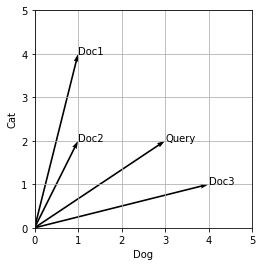

In [3]:
# 出力する画像をJupyter Notebook内に表示するためのおまじない
%matplotlib inline

# 必要なライブラリを読み込む
import matplotlib.pyplot as plt

# 全文書共通のx軸y軸の始点（0, 0）
start_x = 0 # x軸の始点
start_y = 0 # y軸の始点

# 文書1のX軸とY軸の値を索引語の出現回数を使って定義
doc1_x = 1 # x軸の終点（1: いぬの出現頻度）
doc1_y = 4 # y軸の終点（4: ねこの出現頻度）

# 文書2のX軸とY軸の値を索引語の出現回数を使って定義
doc2_x = 1 # x軸の終点（1: いぬの出現頻度）
doc2_y = 2 # y軸の終点（2: ねこの出現頻度）

# 文書3のX軸とY軸の値を索引語の出現回数を使って定義
doc3_x = 4 # x軸の終点（4: いぬの出現頻度）
doc3_y = 1 # y軸の終点（1: ねこの出現頻度）

# 検索質問のX軸とY軸の値を索引語の出現回数を使って定義
query_x = 3 # x軸の終点（3: いぬの出現頻度）
query_y = 2 # y軸の終点（2: ねこの出現頻度）

# 文書1-3と検索質問のベクトル情報を配列に代入
all_x_start = [start_x, start_x, start_x, start_x] # 文書1-3のX軸始点, 検索質問のX軸始点
all_y_start = [start_y, start_y, start_y, start_y] # 文書1-3のY軸始点, 検索質問のY軸始点
all_x_end = [doc1_x, doc2_x, doc3_x, query_x] # 文書1-3のX軸終点, 検索質問のX軸終点
all_y_end = [doc1_y, doc2_y, doc3_y, query_y] # 文書1-3のY軸終点, 検索質問のY軸終点

# グラフの描画
plt.quiver(all_x_start, all_y_start, all_x_end, all_y_end, angles='xy', scale_units='xy', scale=1)
plt.text(1, 4, "Doc1") # 文書ラベルの追加（X軸座標、Y軸座標、ラベル）
plt.text(1, 2, "Doc2") # 文書ラベルの追加（X軸座標、Y軸座標、ラベル）
plt.text(4, 1, "Doc3") # 文書ラベルの追加（X軸座標、Y軸座標、ラベル）
plt.text(3, 2, "Query") # 検索質問の追加（X軸座標、Y軸座標、ラベル）
plt.xlabel("Dog") # X軸ラベルの指定
plt.ylabel("Cat") # Y軸ラベルの指定
plt.axis('scaled')
plt.xlim([0,5])
plt.ylim([0,5])
plt.xticks(range(0,6))
plt.yticks(range(0,6))
plt.grid()
plt.draw()
plt.show()

---
文書1-3のベクトルに加えて、$(3,2)$を終点とした検索質問のベクトルが表示されていたら成功です。

プログラムの変更点は以下の通りです。

> 24-5: 検索質問のベクトル終点を定義  
> 28-31: 配列に検索質問のベクトル終点を追加  
> 38: 検索質問ベクトルのラベルを追加

このように、検索質問も文書と同じベクトル空間に表現することで、

- 文書1と検索質問の類似度 $cos(\vec{a},\vec{q})$
- 文書2と検索質問の類似度 $cos(\vec{b},\vec{q})$
- 文書3と検索質問の類似度 $cos(\vec{c},\vec{q})$

と各文書との類似度が求まり、類似度の高い順に文書を順位付けすることができます。

---
### ベクトル空間モデルのまとめ

ここまで学んできたことをまとめると、以下のようになります。

1. ベクトル空間モデルでは、索引語の統計量（`tf`値など）が次元をなす多次元ベクトルで文書を表現する
1. 検索質問も文書と同様にベクトルとして表現する
1. 検索質問ベクトルと各文書ベクトルの余弦関数（コサイン）を計算して、両者の類似度（＝適合性）とする
1. 計算した類似度の高い順に文書を順位付けして、検索結果とする

> ここまでの例では、ベクトルの値に索引語の文書内における出現頻度（`tf`値）を使いました。
> 残りの演習では、`tf`値の代わりに、前回もとめた`tfidf`値を使います。

それでは実際にプログラムを作成していきましょう。

---
### 索引ファイルの読み込み

今回作成するプログラムの最初の部分は、前回作成した重み情報がついた索引ファイルを読み込んだ辞書オブジェクトを生成することです。`~/CJE3/index/`フォルダに生成した`index2.txt`は以下の構造でした。

```
あっ    sample_doc2.txt 1       1.4663370687934272      1.4663370687934272
あっ    sample_doc3.txt 1       1.4663370687934272      1.4663370687934272
あっ    sample_doc4.txt 1       1.4663370687934272      1.4663370687934272
あと    sample_doc2.txt 1       1.791759469228055       1.791759469228055
あと    sample_doc6.txt 1       1.791759469228055       1.791759469228055
あまりに        sample_doc4.txt 1       2.3978952727983707      2.3978952727983707
...
```

列要素は左から、索引語、文書ファイル名、`tf`値、`idf`値、`tfidf`値、であり、**タブ文字**で区切られています。

それでは、前回学んだことを活用して、以下の処理を行うプログラムを書きましょう。

- `index2.txt`を開く
- 行末改行文字を削除する
- 文字列をタブ文字（`\t`）で分割
- 各行で分割された要素を使って以下の二つの辞書オブジェクトを作成
    - 辞書オブジェクト`idf_scores`（キー：索引語、値：`idf`値）
    - 辞書オブジェクト`tfidf_scores`（キー：索引語、文書ファイル名、値：`tfidf`値）
- `idf_scores`と`tfidf_scores`の中身を確認用に出力

> `idf`値と`tfidf`値を`float`型でキャストするのを忘れずに

In [4]:
# 必要なライブラリを読み込む
import os

# 索引ファイルの指定
f_name = "../index/index2.txt"


# 辞書オブジェクトの初期化
idf_scores = {}
tfidf_scores = {}

# 索引ファイルを開く
f = open(f_name)

# 索引ファイルを1行づつ処理
for line in f:
    # 行末の改行文字除去
    line = line.rstrip()
    # 行の分割
    split_line = line.split("\t")

    # 配列要素
    word = split_line[0] # 索引語
    doc = split_line[1] # ファイル名
    idf = float(split_line[3])
    tfidf = float(split_line[4])
    
 
    # 入れ子辞書オブジェクトの初期化（改良版）
    #dict = {}
    
    idf_scores[word] = idf
    # 辞書オブジェクトへの代入（改良版）
    if word in tfidf_scores:
        tfidf_scores[word][doc] = tfidf
        
    else:
        tfidf_scores[word] = {}
        tfidf_scores[word][doc] = tfidf
        
# 確認出力
for word in idf_scores:
    for doc in tfidf_scores[word]:
        print(word, doc, idf_scores[word], tfidf_scores[word][doc])
        



あっ sample_doc2.txt 1.4663370687934272 1.4663370687934272
あっ sample_doc3.txt 1.4663370687934272 1.4663370687934272
あっ sample_doc4.txt 1.4663370687934272 1.4663370687934272
あと sample_doc2.txt 1.791759469228055 1.791759469228055
あと sample_doc6.txt 1.791759469228055 1.791759469228055
あまりに sample_doc4.txt 2.3978952727983707 2.3978952727983707
ある sample_doc1.txt 0.8109302162163288 0.8109302162163288
ある sample_doc10.txt 0.8109302162163288 0.8109302162163288
ある sample_doc2.txt 0.8109302162163288 0.8109302162163288
ある sample_doc3.txt 0.8109302162163288 0.8109302162163288
ある sample_doc5.txt 0.8109302162163288 0.8109302162163288
ある sample_doc7.txt 0.8109302162163288 0.8109302162163288
ある sample_doc8.txt 0.8109302162163288 0.8109302162163288
ある sample_doc9.txt 0.8109302162163288 1.6218604324326575
あるい sample_doc10.txt 2.3978952727983707 2.3978952727983707
あろ sample_doc3.txt 2.3978952727983707 2.3978952727983707
いか sample_doc10.txt 2.3978952727983707 2.3978952727983707
いくら sample_doc6.txt 2.3978952

---

以下のような出力が得られたら成功です。

```
あっ	sample_doc2.txt	1.4663370687934272	1.4663370687934272
あっ	sample_doc3.txt	1.4663370687934272	1.4663370687934272
あっ	sample_doc4.txt	1.4663370687934272	1.4663370687934272
あと	sample_doc2.txt	1.791759469228055	1.791759469228055
あと	sample_doc6.txt	1.791759469228055	1.791759469228055
あまりに	sample_doc4.txt	2.3978952727983707	2.3978952727983707
...
```

---
### 文書のベクトル表現

それでは前半に学んだ文書のベクトル表現を実装していきましょう。

まずは、今回作成するベクトル空間の次元数を把握しておきましょう。ベクトル空間の次元数＝索引ファイルの語彙数（重複を除いた索引語の数）でした。

そして索引ファイルの語彙数は、以下の手順で数えることができます。

- 辞書オブジェクト`tfidf_scores`のレコードを`for`文で巡回する
- 索引語オブジェクト`words`を作成し、初出の索引語を追加していく（ヒント：`not in`メソッドを使う）
- `for`文のループが終了したら、`words`の大きさを出力する

それでは実装してみましょう。

In [5]:
# 索引語用辞書オブジェクトの初期化
words = {}

# tfidf_scoresを巡回
for word in sorted(tfidf_scores):
    if word not in words:
        words[word] = 1

# wordsの大きさを出力
len(words)

311

---

> 311

のように`tfidf_scores`のレコード数（＝索引語彙数）が出力されたら成功です。

> **注意：** 不要語削除の設定次第では、上記の数字と一致しないかもしれませんが、問題ありません。

つまり、今回順位付けをおこなうベクトル空間は、文書を`311`次元で表現します。表にすると以下のようなイメージになります。

|　|あっ|あと|あまりに|・・・|飲む|
|:--:|:--:|:--:|:--:|:--:|:--:|
|sample_doc1.txt|`tfidf`値|`tfidf`値|`tfidf`値|...|`tfidf`値|
|sample_doc2.txt|`tfidf`値|`tfidf`値|`tfidf`値|...|`tfidf`値|
|sample_doc3.txt|`tfidf`値|`tfidf`値|`tfidf`値|...|`tfidf`値|
|sample_doc4.txt|`tfidf`値|`tfidf`値|`tfidf`値|...|`tfidf`値|
|sample_doc5.txt|`tfidf`値|`tfidf`値|`tfidf`値|...|`tfidf`値|

---
それでは、上記の表のような構造をもつオブジェクトを生成してみましょう。

ここでは、`pandas`というデータ分析用ライブラリを使います。まずは下のプログラムを実行してみてください。

In [6]:
# 必要なライブラリを読み込む
import pandas as pd

# tfidf_scoresからデータフレームを作成
tfidf_table = pd.DataFrame(tfidf_scores)

# 確認用出力
tfidf_table

,あっ,あと,あまりに,ある,あるい,あろ,いか,いくら,いた事,いっ,...,雨,非常,音,頃,顔,風,食う,食物,飲む,餓死
sample_doc1.txt,NaN,NaN,NaN,0.81093,NaN,NaN,NaN,NaN,2.397895,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sample_doc10.txt,NaN,NaN,NaN,0.81093,2.397895,NaN,2.397895,NaN,NaN,1.791759,...,2.397895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.397895
sample_doc2.txt,1.466337,1.791759,NaN,0.81093,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.397895,NaN,NaN,NaN
sample_doc3.txt,1.466337,NaN,NaN,0.81093,NaN,2.397895,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.791759,NaN,NaN,NaN,NaN,NaN
sample_doc4.txt,1.466337,NaN,2.397895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.583519,NaN,NaN,NaN,NaN,NaN
sample_doc5.txt,NaN,NaN,NaN,0.81093,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.397895,NaN,NaN,NaN,NaN,2.397895,NaN
sample_doc6.txt,NaN,1.791759,NaN,NaN,NaN,NaN,NaN,2.397895,NaN,NaN,...,NaN,1.466337,2.397895,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sample_doc7.txt,NaN,NaN,NaN,0.81093,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.466337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sample_doc8.txt,NaN,NaN,NaN,0.81093,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sample_doc9.txt,NaN,NaN,NaN,1.62186,NaN,NaN,NaN,NaN,NaN,1.791759,...,NaN,2.932674,NaN,NaN,NaN,2.397895,NaN,2.397895,NaN,NaN


---
左見出し列にファイル名、上見出し行に索引語、セルに`tfidf`値があるエクセルのような表が出力されたら成功です。

また

> 10 rows × 311 columns

と末尾に表示されたことから、10つの文書ファイルと311の索引語から構成された表であることが確認できます（**索引語数は異なる可能性あり**）。

> このような表形式のデータ構造を**データフレーム**（`Dataframe`）と呼びます。

プログラムの説明は以下の通りです。
> 2: データ分析用ライブラリの読み込み  
> 5: 先に作成した辞書オブジェクト`tfidf_scores`を、`pd.DataFrame`メソッドを用いてデータフレームに変換し、変数`tfidf_table`に代入  
> 8: 確認用の出力

しかし、`NaN`という表示がたくさん出ました。これはそのセルに値がないことを意味しています。これを**欠損値**などとも呼びます。本演習のプログラムでは、欠損値＝0、ですので、`NaN`を`0`に置き換えましょう。

そのためには、欠損値の変換したい`tfidf_table`オブジェクトに対して、`fillna`メソッドを使います。8行目に注意してください。

In [7]:
# 必要なライブラリを読み込む
import pandas as pd

# tfidf_scoresからデータフレームを作成
tfidf_table = pd.DataFrame(tfidf_scores)

# NaNを0に置き換える
tfidf_table = tfidf_table.fillna(0)

# 確認用出力
tfidf_table

,あっ,あと,あまりに,ある,あるい,あろ,いか,いくら,いた事,いっ,...,雨,非常,音,頃,顔,風,食う,食物,飲む,餓死
sample_doc1.txt,0.000000,0.000000,0.000000,0.81093,0.000000,0.000000,0.000000,0.000000,2.397895,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sample_doc10.txt,0.000000,0.000000,0.000000,0.81093,2.397895,0.000000,2.397895,0.000000,0.000000,1.791759,...,2.397895,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.397895
sample_doc2.txt,1.466337,1.791759,0.000000,0.81093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.397895,0.000000,0.000000,0.000000
sample_doc3.txt,1.466337,0.000000,0.000000,0.81093,0.000000,2.397895,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.791759,0.000000,0.000000,0.000000,0.000000,0.000000
sample_doc4.txt,1.466337,0.000000,2.397895,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.583519,0.000000,0.000000,0.000000,0.000000,0.000000
sample_doc5.txt,0.000000,0.000000,0.000000,0.81093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.397895,0.000000,0.000000,0.000000,0.000000,2.397895,0.000000
sample_doc6.txt,0.000000,1.791759,0.000000,0.00000,0.000000,0.000000,0.000000,2.397895,0.000000,0.000000,...,0.000000,1.466337,2.397895,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sample_doc7.txt,0.000000,0.000000,0.000000,0.81093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.466337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sample_doc8.txt,0.000000,0.000000,0.000000,0.81093,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sample_doc9.txt,0.000000,0.000000,0.000000,1.62186,0.000000,0.000000,0.000000,0.000000,0.000000,1.791759,...,0.000000,2.932674,0.000000,0.000000,0.000000,2.397895,0.000000,2.397895,0.000000,0.000000


---
上のプログラムを実行すると、`NaN`が`0.000000`に置き換わった表が出力されます。8行目で実行している通り、`fillna`メソッドに置き換えたい値（この場合は`0`）を引数として渡しています。

> これで全ての文書を`tfidf`値を使ったベクトル空間に表現する準備が整いました。

---
### 検索質問のベクトル表現

次に検索質問をベクトル表現する方法をみていきます。

目標は以下のようなデータフレームを作成することです。

|　|あっ|あと|あまりに|・・・|飲む|
|:--:|:--:|:--:|:--:|:--:|:--:|
|query|`tfidf`値|`tfidf`値|`tfidf`値|...|`tfidf`値|

ご覧の通り、文書用データフレームと同じ構造です。しかし、検索質問には文書ファイル名がありませんので、便宜上`query`というファイル名があるものとして、文書用データとの互換性を保つ工夫をします。

> 一方、既に色々処理をしてきた文書のベクトル表現と比較すると、検索質問のベクトル表現化は少し手間がかかります。

まずは以下の概要をしっかり理解しましょう。索引語（＝文書内の語）と**検索語**（＝検索質問内の語）の区別に注意してください。

1. まずは索引語一覧が必要なので、`idf_scores`のキーを`for`ループで巡回する
1. 巡回しながら、索引語と「query」というファイル名をキーとした検索質問用辞書オブジェクトを初期化しておく（値は`0`）
1. つぎに与えられた検索質問を空白文字で分割し、検索語の配列を作成（例：「京都 観光」→ ['京都', '観光']）
1. 検索語配列をループで巡回し、検索語＝索引語であるレコードの出現頻度（`tf`値）を+1する
1. さらに先に作成した`idf_scores`から検索語の`idf`値を参照し、辞書オブジェクトの値を`tf`から`tfidf`値に置き換える
1. 最後に`pd.DataFrame`メソッドを使って表形式に変換する

これらは全て、今まで学んできた内容で実装できます。

変数名は以下のものを使いましょう。

- 検索質問：`query`
- 互換用ファイル名：`query_file`
- 検索語の配列：`query_words`
- (`for`ループ内の）検索語：`query_word`
- (`for`ループ内の）索引語：`index_word`
- 検索質問用辞書オブジェクト1（`tf`値）：`query_tf`
- 検索質問用辞書オブジェクト2（`tfidf`値）：`query_tfidf`
- 検索質問用データフレーム：`query_table`

それでは、検索質問（`query`）を「あっ 顔」という二つの検索語で構成されるものと仮定して、プログラムを実装してみましょう。

In [8]:
# 必要なライブラリを読み込む
import pandas as pd

# 検索質問用辞書オブジェクト
query_tf = {}
query_tfidf = {}


# 互換用ファイル名
query_file = 'query'

# 索引語を一つずつ処理
for word in idf_scores:
    # 索引語をキーとした入れ子オブジェクトを初期化
    query_tf[word] = {}
    # キー：索引語、擬似文書名「query」、値：0
    query_tf[word][query_file] = 0    

# 検索質問
query = 'あまりに あまりに あっ 顔'

# 検索質問の分割 → 検索語の配列
query_words = query.split(" ")
# 検索語を一つずつ処理
for query_word in query_words:
    # 検索語==索引語なレコードのtf値を+1
    for index_word in idf_scores:
        if query_word == index_word:
            query_tf[index_word][query_file] += 1

# 検索語の出現頻度（`tf`値）と`idf`値を使って、`tfidf`値を算出する
for word in query_tf:
    for q in query_tf[word]:
        tf = query_tf[word][q]
        idf = idf_scores[word]
        tfidf = tf * idf
        query_tfidf[word] = tfidf
#print(query_tfidf)
# query_tfidfをデータフレームに変換
query_table = pd.DataFrame(query_tfidf, index=['query',])

# 確認用出力
query_table

,あっ,あと,あまりに,ある,あるい,あろ,いか,いくら,いた事,いっ,...,雨,非常,音,頃,顔,風,食う,食物,飲む,餓死
query,1.466337,0.0,4.795791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.791759,0.0,0.0,0.0,0.0,0.0


---

「あっ」と「顔」の値が`tfidf`値で、その他の索引語の値が`0`の表が出力されたら成功です。


次に

> query = 'あまりに あまりに あっ 顔'

に変更して、表の値が変わるか確認してみましょう。

**これ以降は「あまりに あまりに あっ 顔」を検索質問として使用した結果例を提示します**


---
### 類似度の計算

文書と検索質問をベクトル表現する準備が整いましたので、両者の類似度を余弦関数を使って計算していきましょう。

ここからは、文書のベクトルを $\vec{d}$、検索質問のベクトルを $\vec{q}$ と表記します。さらに語彙数（＝ベクトル空間の次元数）を $n$ で表記します。

計算式を復習しましょう。

- 余弦関数（変数名：`cosine`）

$
\cos(\vec{d}, \vec{q}) = \frac{\vec{d} \cdot \vec{q}}{|\vec{d}| \cdot |\vec{q}|}
$

- 分子（変数名：`numerator`）

$
\vec{d} \cdot \vec{q} = d_1 \times q_1 + d_2 \times q_2 + \dots + d_n \times q_n
$

- 分母（変数名：`denominator`）

$
|\vec{d}| \cdot |\vec{q}| = \sqrt{ d_1^2 + d_2^2 + \dots + d_n^2 } \times \sqrt{ q_1^2 + q_2^2 + \dots + q_n^2 }
$

---
#### 順位付け対象文書の同定

今回の例では10件の文書しか扱わないので、全ての文書に対し、検索質問との類似度を計測しても大した時間はかかりません。しかし、実際のシステムでは膨大な数の文書を計算することになってしまうので、順位付けの前に、検索語の出現する文書を同定しておき、検索語の出現する文書との類似度のみを計算するのが一般的です。

手順は以下の通りです。

- 対象文書用辞書オブジェクトの初期化
- 検索質問の分割 → 検索語の配列
- 検索語を一つずつ処理
- `tfidf_scores`内で検索語を含む文書を取得

それでは、以下の変数名を使って実装してみましょう。

- 対象文書用辞書オブジェクト：`ranking_docs`
- 検索質問：`query`
- 検索語の配列：`query_words`
- (`for`ループ内の）検索語：`query_word`
- (`for`ループ内の）文書：`doc`

In [9]:
# 必要なライブラリを読み込む
import pandas as pd

# 対象文書用辞書オブジェクトの初期化
ranking_docs = {}

# 検索質問
query = 'あまりに あまりに あっ 顔'

# 検索質問の分割 → 検索語の配列
query_words = query.split(" ")

# 検索語を一つずつ処理
for query_word in sorted(query_words):
    for doc in tfidf_scores[query_word]:
        ranking_docs[doc] = 1

# 確認用出力
ranking_docs

{'sample_doc2.txt': 1, 'sample_doc3.txt': 1, 'sample_doc4.txt': 1}

---

```
{'sample_doc2.txt': 1, 'sample_doc3.txt': 1, 'sample_doc4.txt': 1}
```

と出力されたら成功です。

結果として、検索質問にマッチする順位付け対象となる文書が3つあることがわかりました。

---
#### 余弦関数の計算

順位付けするには、対象となる3つ文書と検索質問ベクトルの類似性を計算する必要がありますが、まずは`sample_doc2.txt`と検索質問の類似度を計算してみましょう。

手順は以下の通りです。

1. 文書と検索質問のデータフレームから類似度を計測するための`tfidf`値を取り出す
1. 文書と検索質問のデータを使って余弦関数の分子と分母を計算する
1. 最後に、余弦関数をもとめて、文書と検索質問の類似度とする。

それでは、まずデータフレームから`sample_doc2.txt`のベクトル表現である`tfidf`値を取り出しましょう。

以下のプログラムを実行してください。

In [10]:
# データフレームから行IDにマッチする行を取得
doc_vec = tfidf_table.loc['sample_doc2.txt']
# 確認用出力
doc_vec

あっ      1.466337
あと      1.791759
あまりに    0.000000
ある      0.810930
あるい     0.000000
あろ      0.000000
いか      0.000000
いくら     0.000000
いた事     0.000000
いっ      0.000000
いとも     2.397895
いる      0.000000
いわゆる    0.000000
うち      0.000000
おかしい    0.000000
おっ      0.000000
かかる     0.000000
かた      0.000000
かも      0.000000
から      0.980829
かん      0.000000
くい      0.000000
くずれ     0.000000
くらい     0.000000
くれる     0.000000
くわし     0.000000
けむり     0.000000
こう      0.000000
ここ      0.000000
この      1.098612
          ...   
訪問      0.000000
試み      0.000000
話       2.397895
誰       0.000000
路傍      0.000000
載せ      0.000000
輪       0.000000
迎       0.000000
這       0.000000
這い出す    0.000000
這入      0.000000
通路      0.000000
速力      0.000000
逢       0.000000
運転      0.000000
違っ      0.000000
邸       0.000000
降っ      0.000000
隠し      0.000000
隣家      0.000000
雨       0.000000
非常      0.000000
音       0.000000
頃       0.000000
顔       0.000000
風       0.000000
食う      2.397895
食物      0.0000

---

```
あっ      1.466337
あと      1.791759
あまりに    0.000000
ある      0.810930
あるい     0.000000
...
```

という出力が得られたら成功です。

`.loc`メソッドは、先ほど作成した文書のデータフレーム`tfidf_doc`から行ID（この場合は、ファイル名`sample_doc2.txt`）にマッチした行のデータを出力します。

しかし、余弦式の計算では、索引語情報は不要ですので、`tfidf`値だけを取り出しましょう。

以下のプログラムを実行してください。

In [11]:
# 文書データフレームから行IDにマッチする行のデータを取得
doc_vec = tfidf_table.loc['sample_doc2.txt']
# 文書2データから数値のみを出力
doc_vec.values

array([1.46633707, 1.79175947, 0.        , 0.81093022, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       2.39789527, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.98082925,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.09861229,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 2.39789527, 2.39789527,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.79175947, 0.        , 0.        , 1.25276297, 0.        ,
       0.        , 1.79175947, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 2.39789527, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

---

```
array([1.46633707, 1.79175947, 0.        , 0.81093022, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       2.39789527, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.98082925,
       0.        , 0.        , 0.        , 0.        , 0.        ,
...
```

という出力が得られたら成功です。

`.loc`メソッドが返したデータから、値のみを取り出すには、`.values`メソッドを使います。

> 以上で、`sample_doc2.txt`を表現するデータが取得できました。

同様のやり方で、検索質問の値（索引語は不要）を取り出して見てください。

- 検索質問データフレーム：`query_table`
- 検索質問用ファイル名：`query`
- 検索質問用ベクトル変数名：`query_vec`

In [12]:
# 検索質問データフレームから行IDにマッチする行のデータを取得
query_vec = query_table.loc['query']
# 検索質問データから数値のみを出力
query_vec.values

array([1.46633707, 0.        , 4.79579055, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

---

```
array([1.46633707, 0.        , 4.79579055, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
...
```

と出力されたら成功です。

> 以上で、文書2（`sample_doc2.txt`）と検索質問のベクトル表現データが入手できました。

---
#### 余弦関数の分子の計算

それでは、両ベクトルの類似度を余弦関数を使って計算していきましょう。

まずは分子です。

$
\vec{d} \cdot \vec{q} = d_1 \times q_1 + d_2 \times q_2 + \dots + d_n \times q_n
$

手順は以下の通りです。

1. 分子を代入する変数`numerator`を初期化（値：0）
1. 検索質問ベクトル`query_vec`の値を`for`ループで巡回する
    1. 文書ベクトル`doc_vec`の要素も同時に巡回するので、添字（配列の位置情報）を使うことに注意
1. `query_vec`と`doc_vec`の$i$番目の要素を掛け合わせる
1. 掛け合わせたものを変数`numerator`に足し合わせていく

以下の例では、計算過程の様子がわかるように、`print`を入れています。

In [13]:
# 変数の初期化
numerator = 0

# 検索質問ベクトルの要素を添字を使って巡回
for i in range(len(query_vec.values)):
    # query_vecとdoc_vecのi番目の要素を掛け合わせる
    i_value = query_vec.values[i] * doc_vec.values[i]
    # 掛け合わせたもの分子に加算する
    numerator = numerator + i_value
    
    # 確認用出力
    print('検索質問：' + query_vec.index[i] + str(query_vec.values[i]) + " x " + '文書2：' + doc_vec.index[i] + str(doc_vec.values[i]) + ' = ' + str(i_value))
    print('分子：' + str(numerator))

検索質問：あっ1.4663370687934272 x 文書2：あっ1.4663370687934272 = 2.1501443993177
分子：2.1501443993177
検索質問：あと0.0 x 文書2：あと1.791759469228055 = 0.0
分子：2.1501443993177
検索質問：あまりに4.795790545596741 x 文書2：あまりに0.0 = 0.0
分子：2.1501443993177
検索質問：ある0.0 x 文書2：ある0.8109302162163288 = 0.0
分子：2.1501443993177
検索質問：あるい0.0 x 文書2：あるい0.0 = 0.0
分子：2.1501443993177
検索質問：あろ0.0 x 文書2：あろ0.0 = 0.0
分子：2.1501443993177
検索質問：いか0.0 x 文書2：いか0.0 = 0.0
分子：2.1501443993177
検索質問：いくら0.0 x 文書2：いくら0.0 = 0.0
分子：2.1501443993177
検索質問：いた事0.0 x 文書2：いた事0.0 = 0.0
分子：2.1501443993177
検索質問：いっ0.0 x 文書2：いっ0.0 = 0.0
分子：2.1501443993177
検索質問：いとも0.0 x 文書2：いとも2.3978952727983707 = 0.0
分子：2.1501443993177
検索質問：いる0.0 x 文書2：いる0.0 = 0.0
分子：2.1501443993177
検索質問：いわゆる0.0 x 文書2：いわゆる0.0 = 0.0
分子：2.1501443993177
検索質問：うち0.0 x 文書2：うち0.0 = 0.0
分子：2.1501443993177
検索質問：おかしい0.0 x 文書2：おかしい0.0 = 0.0
分子：2.1501443993177
検索質問：おっ0.0 x 文書2：おっ0.0 = 0.0
分子：2.1501443993177
検索質問：かかる0.0 x 文書2：かかる0.0 = 0.0
分子：2.1501443993177
検索質問：かた0.0 x 文書2：かた0.0 = 0.0
分子：2.1501443993177
検索質問：かも0.0 x 文

---

```
検索質問：あっ1.4663370687934272 x 文書2：あっ1.4663370687934272 = 2.1501443993177
分子：2.1501443993177
検索質問：あと0.0 x 文書2：あと1.791759469228055 = 0.0
分子：2.1501443993177
...
```

と出力されたら成功です。

毎行ごとに、ある索引語に対する検索質問と文書2の`tfidf`値が掛け合わされて、分子に加算されていく様子がわかると思います。実際には、多くの索引語の値が`0`である（＝検索質問や文書2に出現しない）こともわかります。

> 以上が余弦式の分子の計算です。

---
#### 余弦関数の分母の計算

次に、分母を計算しましょう。

$
|\vec{d}| \cdot |\vec{q}| = \sqrt{ d_1^2 + d_2^2 + \dots + d_n^2 } \times \sqrt{ q_1^2 + q_2^2 + \dots + q_n^2 }
$

手順は以下の通りです。

1. 平方根を計算するために必要な`math`ライブラリを読み込む
1. 分母を計算するために必要な変数群を初期化（値：0）
1. 検索質問ベクトル`query_vec`の値を`for`ループで巡回する
    1. 文書ベクトル`doc_vec`の要素も同時に巡回するので、添字（配列の位置情報）を使うことに注意
    1. `query_vec`の$i$番目の要素の二乗を`query_value`に加算する
    1. `doc_vec`の$i$番目の要素の二乗を`doc_value`に加算する
1. 最後に、`query_vec`と`doc_vec`の平方根を掛け合わせて、分母とする
    1. 変数の平方根を計算するには、`math.sqrt(変数)`を用います

分子の計算を参考にプログラムを完成させましょう。

用いる変数は

- 検索質問ベクトルの合計値：`query_value`
- 文書ベクトルの合計値：`doc_value`
- （最終的に求める）分母：`denominator`

です。

分子の計算と同様に、計算過程の様子がわかるように、`print`を入れています。

In [14]:
# 必要なライブラリを読み込む
import math

# 変数の初期化
query_value = 0
doc_value = 0
denominator = 0

# 検索質問ベクトルの要素を添字を使って巡回
for i in range(len(query_vec.values)):
    # 検索質問ベクトルのi番目の値の二乗をquery_valueに加算していく
    query_value += query_vec[i] ** 2
    # 文書ベクトルのi番目の値の二乗をdoc_valueに加算していく
    doc_value += doc_vec[i] ** 2
    
    
    # 確認用出力
    print('検索質問：' + query_vec.index[i] + str(query_vec.values[i]) + " x " +  str(query_vec.values[i]) + " = " + str(query_vec.values[i] * query_vec.values[i]) + " 合計：" + str(query_value))
    print('文書2：' + doc_vec.index[i] + str(doc_vec.values[i]) + " x " +  str(doc_vec.values[i]) + " = " + str(doc_vec.values[i] * doc_vec.values[i]) + " 合計：" + str(doc_value))

# query_valueとdoc_valueの平方根を掛け合わせて分母とする
denominator = math.sqrt(query_value) * math.sqrt(doc_value)

# 確認用出力
print('検索質問（平方根）：' + str(math.sqrt(query_value)) + " x " + '文書2（平方根）：' + str(math.sqrt(doc_value)))
print('分母：' + str(denominator))

検索質問：あっ1.4663370687934272 x 1.4663370687934272 = 2.1501443993177 合計：2.1501443993177
文書2：あっ1.4663370687934272 x 1.4663370687934272 = 2.1501443993177 合計：2.1501443993177
検索質問：あと0.0 x 0.0 = 0.0 合計：2.1501443993177
文書2：あと1.791759469228055 x 1.791759469228055 = 3.210401995568401 合計：5.360546394886101
検索質問：あまりに4.795790545596741 x 4.795790545596741 = 22.99960695723509 合計：25.14975135655279
文書2：あまりに0.0 x 0.0 = 0.0 合計：5.360546394886101
検索質問：ある0.0 x 0.0 = 0.0 合計：25.14975135655279
文書2：ある0.8109302162163288 x 0.8109302162163288 = 0.6576078155726617 合計：6.018154210458762
検索質問：あるい0.0 x 0.0 = 0.0 合計：25.14975135655279
文書2：あるい0.0 x 0.0 = 0.0 合計：6.018154210458762
検索質問：あろ0.0 x 0.0 = 0.0 合計：25.14975135655279
文書2：あろ0.0 x 0.0 = 0.0 合計：6.018154210458762
検索質問：いか0.0 x 0.0 = 0.0 合計：25.14975135655279
文書2：いか0.0 x 0.0 = 0.0 合計：6.018154210458762
検索質問：いくら0.0 x 0.0 = 0.0 合計：25.14975135655279
文書2：いくら0.0 x 0.0 = 0.0 合計：6.018154210458762
検索質問：いた事0.0 x 0.0 = 0.0 合計：25.14975135655279
文書2：いた事0.0 x 0.0 = 0.0 合計：6.018154210458762


---

```
検索質問：あっ1.4663370687934272 x 1.4663370687934272 = 2.1501443993177 合計：2.1501443993177
文書2：あっ1.4663370687934272 x 1.4663370687934272 = 2.1501443993177 合計：2.1501443993177
検索質問：あと0.0 x 0.0 = 0.0 合計：2.1501443993177
文書2：あと1.791759469228055 x 1.791759469228055 = 3.210401995568401 合計：5.360546394886101
...
検索質問（平方根）：5.325425180407776 x 文書2（平方根）：12.046552523058125
分母：64.15301414339856
```

と出力されたら成功です。出力の最後の2行が、各要素の計算の結果を使って分母を求めています。

> このように数式をプログラムで書くことによって、実際の計算過程が見えるので、アルゴリズムのような抽象的な処理も、より具体的に理解できるのではないでしょうか。

---
#### 余弦関数の計算

分子と分母を得たので、余弦関数を計算しましょう。

$
\cos(\vec{d}, \vec{q}) = \frac{\vec{d} \cdot \vec{q}}{|\vec{d}| \cdot |\vec{q}|}
$

用いる変数は

- 分子：`numerator`
- 分母：`denominator`
- 余弦関数：`cosine`

です。

In [15]:
# 余弦関数の計算
cosine = numerator / denominator
# 確認用出力
print('分子：' + str(numerator) + ' / ' + '分母：' + str(denominator) + ' = ' + str(cosine))

分子：2.1501443993177 / 分母：64.15301414339856 = 0.033515874944107404


---

```
分子：2.1501443993177 / 分母：64.15301414339856 = 0.033515874944107404
```

と出力されたら成功です。

> これで、検索質問と文書2の類似度が計算できました。

---
#### 複数文書の類似度計算と順位付け

それでは、最後に索引語にマッチする文書すべてに対して類似度を計算し、数値の大きい順に対象文書を並び替えるプログラムを書きましょう。

`tfidf_table`と`query_table`は既に構築したものを流用して構いません。

主な手順は以下の通りです。

1. 必要なライブラリを読み込む
1. 対象文書用辞書オブジェクト`ranking_docs`の初期化
1. 検索質問の分割 → 検索語の配列
1. 順位付け対象文書の同定
1. 対象文書を一つずつ処理
    1. 余弦関数の分子の計算
    1. 余弦関数の分母の計算
    1. 余弦関数の計算
1. 類似度の高い順に文書を表示

辞書オブジェクト`ranking_docs`を値の降順（大きい値→小さい値）に並べるのは、`sorted`メソッドに以下のようなオプションを追加します。

```
sorted(ranking_docs.items(), key=lambda x:x[1], reverse=True)
```

- `ranking_docs.items()`：ソートしたい辞書オブジェクトのレコード一覧
- `key=lambda x:x[1]`：キーではなく、値でソートするオプション
- `reverse=True`：ソート順を昇順から降順に変更するオプション

あまり見やすい書き方とは言えませんが、`python`でこのようなお作法になっていますので、このまま使用しましょう。

In [16]:
# 必要なライブラリを読み込む
import math
import pandas as pd
# 対象文書用辞書オブジェクトの初期化
ranking_docs = {}

# 検索質問
query = 'あまりに あまりに あっ 顔'

# 検索質問の分割 → 検索語の配列
query_words = query.split(" ")

# 順位付け対象文書の同定
for query_word in query_words:
    for doc in tfidf_scores[query_word]:
        # 値`1`で初期化
        ranking_docs[doc] = 1

# 対象文書を一つずつ処理
for doc in ranking_docs:
    doc_vec = tfidf_table.loc[doc]
    query_vec = query_table.loc['query']
    
    numerator = 0
    query_value = 0
    doc_value = 0
    denominator = 0
    
    # 検索質問ベクトルの要素を添字を使って巡回
    # 分子の計算
    for i in range(len(query_vec.values)):
        # query_vecとdoc_vecのi番目の要素を掛け合わせる
        i_value = query_vec.values[i] * doc_vec.values[i]
        # 掛け合わせたもの分子に加算する
        numerator += i_value

        # 分母の計算
        # 検索質問ベクトルのi番目の値の二乗をquery_valueに加算していく
        query_value += query_vec.values[i] ** 2
        # 文書ベクトルのi番目の値の二乗をdoc_valueに加算していく
        doc_value += doc_vec.values[i] ** 2
    
    # query_valueとdoc_valueの平方根を掛け合わせて分母とする
    denominator = math.sqrt(query_value) * math.sqrt(doc_value)
    
    # 余弦の計算
    cosine = numerator / denominator
    # ranking_docs[doc]の値をcosineで置き換える
    ranking_docs[doc] = cosine

# 類似度の高い順に文書を出力
sorted(ranking_docs.items(), key=lambda x:x[1], reverse=True)

[('sample_doc4.txt', 0.27388411271851754),
 ('sample_doc3.txt', 0.07194601593898053),
 ('sample_doc2.txt', 0.033515874944107404)]

---

```
[('sample_doc4.txt', 0.27388411271851754),
 ('sample_doc3.txt', 0.07194601593898053),
 ('sample_doc2.txt', 0.033515874944107404)]
```

と出力されたら成功です。

各文書の類似度のスコアから

> 文書4 → 文書3 → 文書2の順で、検索質問との類似度が高いという結果になりました。

以上が、ベクトル空間モデルを用いた文書の順位付け処理です。

---
### プログラムの説明文を書く

それでは、本Notebookの最後の演習として、文書を順位付けするプログラムの説明文を書きましょう。説明文を書く上での注意点はNotebook1を参照してください。


> 2: 数学処理を扱うmathライブラリをインポート

> 3: データ分析ライブラリのpandasをpdとしてインポート

> 5: 対象文書用辞書オブジェクトを初期化

> 8: 検索質問文を用意

> 11: 検索質問文をsplitメソッドを用いて分割し, query_wordsに保存

> 14: 配列query_wordsの要素を1つずつquery_wordとして取り出し, 配列の最後の要素まで繰り返す

> 15: 辞書オブジェクトtfidf_scoresでquery_wordをキーとする要素をdocとして取り出し, 最後の要素まで繰り返す

> 18: 辞書オブジェクトranking_docsにおいてキーdoc, 値を1で初期化する

> 20: 辞書オブジェクトranking_docsのキーをdocとして取り出し, 最後の要素まで繰り返す

> 21~22: locメソッドを用いてデータフレームから行IDにマッチする行のデータを取得し, それぞれ変数doc_vec, query_vecに保存

> 24~27: 計算に使う変数の初期化

> 31: valuesメソッドを用いてquery_vecの値だけを取得し, lenメソッドを用いてquery_vec.valuesの要素数を取得してその数だけ添字iとして以下の処理を繰り返す

> 33: query_vecとdoc_vecのi番目の値を掛け合わせ, i_valueとして保存

> 35: 変数numeratorにi_valueをインクリメントする

> 39: 変数query_valueにquery_vecのi番目の値の2乗をインクリメントする

> 41: 変数doc_valueにdoc_vecのi番目の値の2乗をインクリメントする

> 44: query_valueとdoc_valueの平方根を掛け合わせそれを変数denominatorとして保存する

> 47: 余弦をベクトル空間モデルの定義に基づいて計算し, 変数cosineに保存

> 49: 辞書オブジェクトranking_docsのdocをキーとする値をcosineに書き換える

> 52: 辞書オブジェクトranking_docsについて値でソートし降順で表示する

---
## ここまで完成したら、TAか教員に確認してもらってから、ノートブック5にいきましょう。

### チェックポイント

- プログラムが期待通りに動作するか、索引ファイルは作成されているか
- ノートブックで説明したやり方に沿ってプログラムが書かれているか（我流で書いていないか）
- `matplotlib`や`pandas`が何をするために必要なライブラリか説明できるか
- 24行目などの`doc_vec = tfidf_table.loc[doc]`の`.loc`メソッドが何をしているか正確に説明できるか
- 26行目などの`for i in range(len(query_vec.values)):`の`len`メソッドや`.values`メソッドが何をしているか正確に説明できるか
- 44行目の`sorted(ranking_docs.items(), key=lambda x:x[1], reverse=True)`が値によるソートを行なっていることを説明できるか
- 説明文にライブラリ・クラス・変数・メソッド・ループなどのキーワードを正確に使用しているか

---
Copyright &copy; 2019. Hideo Joho and Haitao Yu. All rights reserved.  
無断複製・転載・配布行為を禁止します。